<a href="https://colab.research.google.com/github/mayaarosama/Kaggle-Projects/blob/main/60k_Stackoverflow_helper_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

## This is a dataset containing 60,000 Stack Overflow questions from 2016-2020. Questions are classified into three categories:

* HQ: High-quality posts without a single edit.
* LQ_EDIT: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes.
* LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.

## **Aim** - To apply two tasks on this dataset; build a classifier model that would classify the post into one of these three classes, and build a predition model that would predict the tags of a given post

## The notebook is divided into:
* data cleaning and analysis section
* classical ML methods to apply the classification
* Deep NN model for the classification using Bi-LSTM network
* Deel NN model for the tagging

Dataset is downloaded from Kaggle [60k Stack Overflow Questions with Quality Rating](https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate?resource=download)

# Loading the data from Kaggle

You may need to use the Kaggle API token to load data into Google Colab environment.

**Note** - This is only for Google Colab users.

In [ ]:
!unzip *.zip
'''
unzipping all zip files in content (the defult directory when working in colab)
if you want to only zip one zip file you can write its name instead of *
the content of the zip file will be extracted "here"
so if the zip file contains a folder you have to move 'cd' to the directory if needed
'''

Archive:  archive (2).zip
  inflating: train.csv               
  inflating: valid.csv               


'\nunzipping all zip files in content (the defult directory when working in colab)\nif you want to only zip one zip file you can write its name instead of *\nthe content of the zip file will be extracted "here"\nso if the zip file contains a folder you have to move \'cd\' to the directory if needed\n'

# Importing Libraries

In [ ]:
import numpy as np # For vector operations
import pandas as pd #To handle the dataframe
import matplotlib.pyplot as plt # To display/plot the results and analysis
import re #regular expression to help clean the text
import random
import seaborn as sns

# Importing all classical models from SKlearn which contains all the models predefined
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics

import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Preparation

In [ ]:
df_train = pd.read_csv("train.csv")
df_train.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [ ]:
def plot_class_counts(df, column_name):
    # Count the occurrences of each class
    class_counts = df[column_name].value_counts()
    print(class_counts)
    # Plot the count of classes
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Class Counts')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()



Y
LQ_CLOSE    15000
HQ          15000
LQ_EDIT     15000
Name: count, dtype: int64


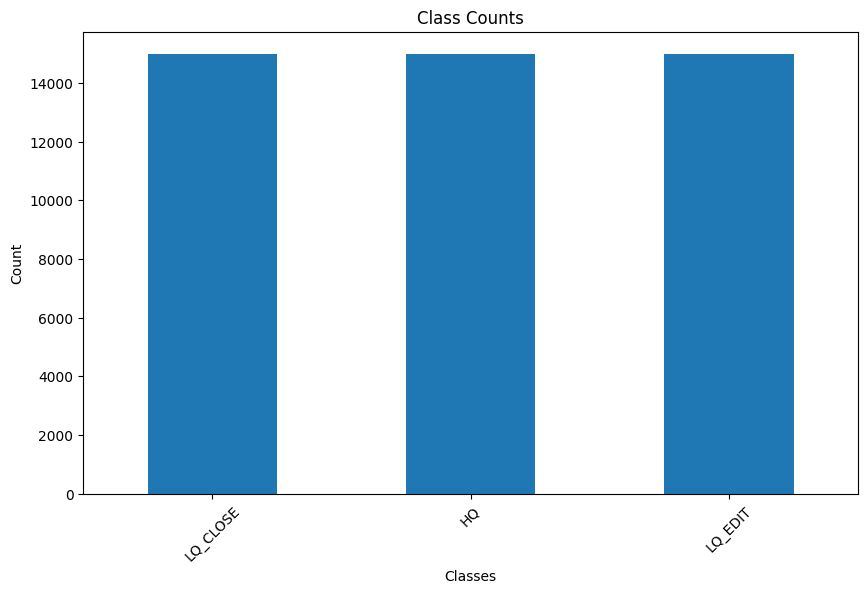

In [ ]:
plot_class_counts(df_train,'Y')

In [ ]:
df_train.count()

Id              45000
Title           45000
Body            45000
Tags            45000
CreationDate    45000
Y               45000
dtype: int64

Checking for nulls in training dataset.

In [ ]:
df_train.isna().sum()

Id              0
Title           0
Body            0
Tags            0
CreationDate    0
Y               0
dtype: int64

In [ ]:
df_train.isna().sum().sum() #to count the total occurrences of null in all columns

0

In [ ]:
df_val = pd.read_csv("valid.csv")
df_val.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT


In [ ]:
df_val.count()

Id              15000
Title           15000
Body            15000
Tags            15000
CreationDate    15000
Y               15000
dtype: int64

Checking for nulls in validation dataset.


In [ ]:
df_val.isna().sum().sum()

0

# Data Preprocessing and Analysis

## Dropping ID and CreationDate.


In [ ]:
df_train = df_train.drop(['Id', 'CreationDate'], axis=1)
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
df_train.head()

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2


In [ ]:
df_val = df_val.drop(['Id', 'CreationDate'], axis=1)
df_val['Y'] = df_val['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
df_val.head()

,Title,Body,Tags,Y
0,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,1
1,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,1
2,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2
3,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,1
4,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,1


### We join the title and the body of the provided text data to leverage both during classification process.

In [ ]:
df_train['concat_text'] = df_train['Title'] + ' ' + df_train['Body']
df_train = df_train.drop(['Title', 'Body'], axis=1)
df_train.head()

,Tags,Y,concat_text
0,<java><repeat>,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,<java><optional>,2,Why are Java Optionals immutable? <p>I'd like ...
2,<javascript><image><overlay><react-native><opa...,2,Text Overlay Image with Darkened Opacity React...
3,<swift><operators><whitespace><ternary-operato...,2,Why ternary operator in swift is so picky? <p>...
4,<android><material-design><floating-action-but...,2,hide/show fab with scale animation <p>I'm usin...


In [ ]:
df_val['concat_text'] = df_val['Title'] + ' ' + df_val['Body']
df_val = df_val.drop(['Title', 'Body'], axis=1)
df_val.head()

,Tags,Y,concat_text
0,<sql><sql-server>,1,How to get all the child records from differen...
1,<php><mysql><sql><codeigniter><mysqli>,1,Retrieve all except some data of the another t...
2,<python><pandas>,2,Pandas: read_html <p>I'm trying to extract US ...
3,<sql-server><c#-4.0>,1,"Reader Always gimme NULL I'm so new to C#, I w..."
4,<php>,1,php rearrange array elements based on conditio...


## Defining a custom text cleaning function


In [ ]:
def process_text_column(df, column_name):
    # Defining the pattern of the paragraph begining and end to remove
    pattern = re.compile(r'<p>|</p>')
    #applying the removal
    df[column_name] =
    df[column_name]
    .apply(lambda x: pattern.sub('', x))

    df[column_name] =
    df[column_name].apply(remove_stopwords_and_punctuation_from_text)
    return df

def remove_stopwords_and_punctuation_from_text(text):
    nltk_stop_words = set(stopwords.words('english'))

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    punctuation
    ='!"$%&()*,-./:;<=>?@[\\]^_`{|}~'
    # Remove stopwords and punctuation
    filtered_tokens = [word for word in tokens if word.lower() not in nltk_stop_words and word not in punctuation]
    # Join the tokens back into a string
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

    # Remove stopwords and punctuation from each text in the column


In [ ]:
def process_tags_column(df, column_name):
    # Replace '><' with ',' to allow the tags to be discrete
    df[column_name] = df[column_name].str.replace('><', ' ', regex=False)
    # Remove '<' and '>' as we will convert the cell into a list with , separating the tags
    df[column_name] = df[column_name].str.replace('[<>]', '', regex=True)
    return df

In [ ]:
df_train = process_tags_column(df_train, 'Tags')
df_train = process_text_column(df_train, 'concat_text')
df_train.head()

,Tags,Y,concat_text
0,java repeat,0,Java Repeat Task Every Random Seconds 'm alrea...
1,java optional,2,Java Optionals immutable 'd like understand Ja...
2,javascript image overlay react-native opacity,2,Text Overlay Image Darkened Opacity React Nati...
3,swift operators whitespace ternary-operator op...,2,ternary operator swift picky question simple c...
4,android material-design floating-action-button,2,hide/show fab scale animation 'm using custom ...


In [ ]:
df_val = process_tags_column(df_val, 'Tags')
df_val = process_text_column(df_val, 'concat_text')
df_val.head()

,Tags,Y,concat_text
0,sql sql-server,1,get child records different tables based given...
1,php mysql sql codeigniter mysqli,1,Retrieve except data another table two table m...
2,python pandas,2,Pandas read_html 'm trying extract US states w...
3,sql-server c#-4.0,1,Reader Always gim NULL 'm new C # wan na make ...
4,php,1,php rearrange array elements based condition b...


To get the longest text to use it for the max_length when generating the embeddings

In [ ]:
df_train['concat_text'][:2].apply(nltk.word_tokenize)

0    [Java, Repeat, Task, Every, Random, Seconds, '...
1    [Java, Optionals, immutable, 'd, like, underst...
Name: concat_text, dtype: object

In [ ]:
df_train['concat_text'][:2].apply(nltk.word_tokenize).apply(len)

0    41
1    12
Name: concat_text, dtype: int64

In [ ]:
df_train['Tags'][:2].str.split()

0      [java, repeat]
1    [java, optional]
Name: Tags, dtype: object

In [ ]:
df_train['text_count']=df_train['concat_text'].apply(nltk.word_tokenize).apply(len)
df_train['tags_count']=df_train['Tags'].str.split().apply(len)
df_train.head()

,Tags,Y,concat_text,text_count,tags_count
0,java repeat,0,Java Repeat Task Every Random Seconds 'm alrea...,41,2
1,java optional,2,Java Optionals immutable 'd like understand Ja...,12,2
2,javascript image overlay react-native opacity,2,Text Overlay Image Darkened Opacity React Nati...,429,5
3,swift operators whitespace ternary-operator op...,2,ternary operator swift picky question simple c...,83,5
4,android material-design floating-action-button,2,hide/show fab scale animation 'm using custom ...,31,3


In [ ]:
df_val['text_count']=df_val['concat_text'].apply(nltk.word_tokenize).apply(len)
df_val['tags_count']=df_val['Tags'].str.split().apply(len)
df_val.head()

,Tags,Y,concat_text,text_count,tags_count
0,sql sql-server,1,get child records different tables based given...,62,2
1,php mysql sql codeigniter mysqli,1,Retrieve except data another table two table m...,21,5
2,python pandas,2,Pandas read_html 'm trying extract US states w...,100,2
3,sql-server c#-4.0,1,Reader Always gim NULL 'm new C # wan na make ...,93,2
4,php,1,php rearrange array elements based condition b...,264,1


In [ ]:
df_train['Tags']=df_train['Tags'].str.split()
df_train.head()

,Tags,Y,concat_text,text_count,tags_count
0,"[java, repeat]",0,Java Repeat Task Every Random Seconds 'm alrea...,41,2
1,"[java, optional]",2,Java Optionals immutable 'd like understand Ja...,12,2
2,"[javascript, image, overlay, react-native, opa...",2,Text Overlay Image Darkened Opacity React Nati...,429,5
3,"[swift, operators, whitespace, ternary-operato...",2,ternary operator swift picky question simple c...,83,5
4,"[android, material-design, floating-action-but...",2,hide/show fab scale animation 'm using custom ...,31,3


In [ ]:
df_val['Tags']=df_val['Tags'].str.split()
df_val.head()

,Tags,Y,concat_text,text_count,tags_count
0,"[sql, sql-server]",1,get child records different tables based given...,62,2
1,"[php, mysql, sql, codeigniter, mysqli]",1,Retrieve except data another table two table m...,21,5
2,"[python, pandas]",2,Pandas read_html 'm trying extract US states w...,100,2
3,"[sql-server, c#-4.0]",1,Reader Always gim NULL 'm new C # wan na make ...,93,2
4,[php],1,php rearrange array elements based condition b...,264,1


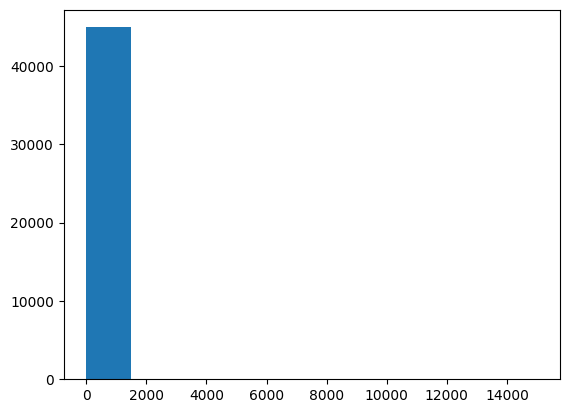

In [ ]:
plt.hist(df_train['text_count'].values,range=(0,15000))
plt.show()

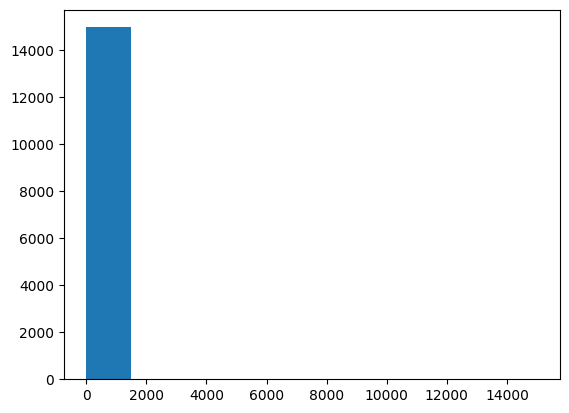

In [ ]:
plt.hist(df_val['text_count'].values,range=(0,15000))
plt.show()

In [ ]:
df_train['text_count'].max()

8612

In [ ]:
df_train.shape

(45000, 5)

In [ ]:
df_train[df_train['text_count'] >500].count()


Tags           802
Y              802
concat_text    802
text_count     802
tags_count     802
dtype: int64

In [ ]:
df_train=df_train[df_train['text_count']<=500]

In [ ]:
df_train.shape

(44198, 5)

In [ ]:
df_train['tags_count'].max()

6

In [ ]:
df_val.shape

(15000, 5)

In [ ]:
df_val[df_val['text_count'] >500].count()


Tags           263
Y              263
concat_text    263
text_count     263
tags_count     263
dtype: int64

In [ ]:
df_val=df_val[df_val['text_count']<=500]

In [ ]:
df_val.shape

(14737, 5)

In [ ]:
set_of_tags = set()
for row in df_train['Tags'][:3]:
  print("row ",row)
  for tag in row:
    print("tag ",tag)
    set_of_tags.add(tag)
  print("set ",set_of_tags)

row  ['java', 'repeat']
tag  java
tag  repeat
set  {'repeat', 'java'}
row  ['java', 'optional']
tag  java
tag  optional
set  {'repeat', 'optional', 'java'}
row  ['javascript', 'image', 'overlay', 'react-native', 'opacity']
tag  javascript
tag  image
tag  overlay
tag  react-native
tag  opacity
set  {'optional', 'java', 'opacity', 'overlay', 'react-native', 'javascript', 'repeat', 'image'}


In [ ]:
set_of_tags = set()
for row in df_train['Tags']:
  for tag in row:
    set_of_tags.add(tag)
for row in df_val['Tags']:
  for tag in row:
    set_of_tags.add(tag)
len(set_of_tags)

10592

In [ ]:
dic_climate={"climate change":0,"paris agreeement": 0}

In [ ]:
# if you want to know how many times each tag occured manually (we will use a defined function to do it for us but for the sack of analysis)
tags_counter={}
for row in df_train['Tags']:
  for tag in row:
    if(tag in tags_counter):
      tags_counter[tag]+=1
    else:
      tags_counter[tag]=0
for row in df_val['Tags']:
  for tag in row:
    if(tag in tags_counter):
      tags_counter[tag]+=1
    else:
      tags_counter[tag]=0

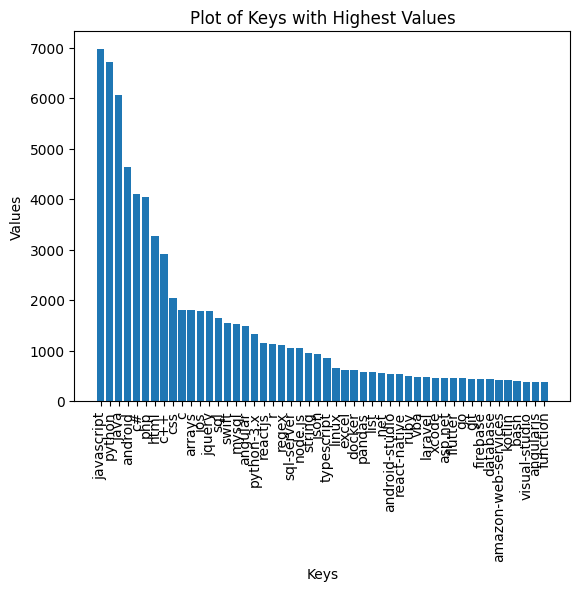

In [ ]:
# Sort the dictionary by values in descending order
sorted_data = sorted(tags_counter.items(), key=lambda x: x[1], reverse=True)

# Extract keys and values from the sorted dictionary
keys = [item[0] for item in sorted_data]
values = [item[1] for item in sorted_data]

# Plot only the keys with the highest values (e.g., top 2)
num_top_keys = 50
plt.bar(keys[:num_top_keys], values[:num_top_keys])
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Plot of Keys with Highest Values')
plt.xticks(rotation='vertical')
plt.show()

## Checking sizes of training and validation datasets

In [ ]:
print("Shape of training dataset size :",df_train.shape)
print("Shape of validation dataset size :",df_val.shape)

Shape of training dataset size : (44198, 5)
Shape of validation dataset size : (14737, 5)


## Assigning X and Y values

### For both training and validation datasets -

*   X Variable - Cleaned text
*   Y Variable - Y



In [ ]:
X_train = df_train['concat_text']
Y_train = df_train['Y'].values

In [ ]:
X_train[:3]

In [ ]:
Y_train[:3]

In [ ]:
X_val = df_val['concat_text']
Y_val = df_val['Y'].values

## Vectorization of data

### Vectorizer : TF-IDF Vectorizer

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus.


We load the TF-IDF vectorizer, first we fit it on training dataset and then transform it on validation dataset.

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

# ML Modelling

We approach the problem by building ML Models from simple to complex models on training set and then assess them on the basis of their scores on validation dataset.

## Classical Approaches

### Multinomial Naive Bayes

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, Y_train)

In [ ]:
nb_val_accuracy = nb_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_val_accuracy)*100:.2f}%")

In [ ]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(nb_classifier, X_val, Y_val)

### Logistic Regression

In [ ]:
lr_classifier = LogisticRegression(C=1.)
lr_classifier.fit(X_train, Y_train)

In [ ]:
lr_val_accuracy = lr_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Logisitic Regression Classifier is: {(lr_val_accuracy )*100:.2f}%")

In [ ]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(lr_classifier, X_val, Y_val)

### KNN Classifier

In [ ]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, Y_train)

In [ ]:
knn_val_accuracy = knn_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of KNN Clf. is: {(knn_val_accuracy)*100:.2f}%")

In [ ]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(knn_classifier, X_val, Y_val)

### Decision Tree Classifier

In [ ]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, Y_train)

In [ ]:
dt_val_accuracy = dt_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_val_accuracy)*100:.2f}%")

In [ ]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(dt_classifier, X_val, Y_val)

### Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, Y_train)

In [ ]:
rf_val_accuracy = rf_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_val_accuracy)*100:.2f}%")

In [ ]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(rf_classifier, X_val, Y_val)

### MLP Classifier

In [ ]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, Y_train)

In [ ]:
mlp_val_accuracy = mlp_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of MLP Classifier is: {(mlp_val_accuracy)*100:.2f}%")

In [ ]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_val, Y_val)

## Scoring ML Model Performance

### List of Validation Accuracies

In [ ]:
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Logisitic Regression is: {(lr_val_accuracy )*100:.2f}%")
print(f"Validation Accuracy of KNN Clf. is: {(knn_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of MLP Classifier is: {(mlp_val_accuracy)*100:.2f}%")

# Tensorflow Approach


## Bi-LSTM MultiClass Classification Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:

# Parameters
embedding_dim = 64
units = 128
trunc_type='post'
padding_type='post'
max_length=500

In [ ]:
tokenizer =
Tokenizer(num_words=None,#By default the value of num_words is none  best value is the vocab_size
                      filters='!"$%&()*,-./:;<=>?@[\\]^_`{|}~\t\n', #filter the text from punctuation we kept # and + for C# and C++
                      lower=True,
                      split=" ",#if you split with , or something else then this will be your splitter
                      char_level=False, #tokenization as char level or word level
                      oov_token=None) #what to replace an oov word with during training validation or testing



In [ ]:
tokenizer.fit_on_texts(df_train['concat_text'].values)

In [ ]:
tokenizer.word_index

{"''": 1,
 'code': 2,
 "'": 3,
 'pre': 4,
 'gt': 5,
 'lt': 6,
 '1': 7,
 '0': 8,
 '2': 9,
 'string': 10,
 'com': 11,
 'class': 12,
 '#': 13,
 'new': 14,
 'using': 15,
 'int': 16,
 'error': 17,
 'get': 18,
 'data': 19,
 '3': 20,
 'name': 21,
 'file': 22,
 'id': 23,
 'https': 24,
 'android': 25,
 'like': 26,
 "n't": 27,
 'java': 28,
 'want': 29,
 'a': 30,
 '+': 31,
 'function': 32,
 'return': 33,
 'value': 34,
 'use': 35,
 'c': 36,
 "'m": 37,
 'public': 38,
 'strong': 39,
 'li': 40,
 'app': 41,
 'i': 42,
 '5': 43,
 '4': 44,
 'href': 45,
 'text': 46,
 "'s": 47,
 'type': 48,
 'array': 49,
 'div': 50,
 'list': 51,
 'x': 52,
 'user': 53,
 'would': 54,
 'one': 55,
 'input': 56,
 'help': 57,
 'need': 58,
 'import': 59,
 'n': 60,
 'b': 61,
 'stack': 62,
 'var': 63,
 'image': 64,
 'rel': 65,
 'html': 66,
 'way': 67,
 '10': 68,
 'void': 69,
 'system': 70,
 'trying': 71,
 'noreferrer': 72,
 'js': 73,
 'print': 74,
 'number': 75,
 'imgur': 76,
 'add': 77,
 'line': 78,
 'php': 79,
 'true': 80,
 'http

In [ ]:
vocab_size = len(tokenizer.word_index) + 1 #+1 for the UNK or OutOfVocab token
X_train = tokenizer.texts_to_sequences(df_train['concat_text'].values)
X_test = tokenizer.texts_to_sequences(df_val['concat_text'].values)

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=max_length) #post so padding will be added at the end
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

In [ ]:
Y_train = df_train['Y'].values
Y_test = df_val['Y'].values

In [ ]:
# Model Definition with biLSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Set the training parameters
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
model.fit(X_train, Y_train, epochs=2)

# Evaluate the model
model.evaluate(X_test, Y_test)

In [ ]:
testing_text=df_val['concat_text'][1001]
actual_class=df_val['Y'][1001]

In [ ]:
actual_class

In [ ]:
test_seq=tokenizer.texts_to_sequences([testing_text])
test_seq=pad_sequences(test_seq, padding='post', maxlen=max_length)
predictions=model.predict(test_seq)
predictions

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

## Bi-LSTM Tagging Model

In [ ]:
df_train["Tags"].values

array([list(['java', 'repeat']), list(['java', 'optional']),
       list(['javascript', 'image', 'overlay', 'react-native', 'opacity']),
       ..., list(['azure', 'billing']), list(['ios', 'swift']),
       list(['c#', 'visual-studio'])], dtype=object)

In [ ]:
# df_train_filtered=pd.concat([df_train,df_val])

In [ ]:
terms = tf.ragged.constant(df_train["Tags"].values)
terms

<tf.RaggedTensor [[b'java', b'repeat'], [b'java', b'optional'],
 [b'javascript', b'image', b'overlay', b'react-native', b'opacity'], ...,
 [b'azure', b'billing'], [b'ios', b'swift'], [b'c#', b'visual-studio']]>

In [ ]:
lookup = tf.keras.
layers.StringLookup(output_mode="multi_hot",
                                      max_tokens=500)
'''
output_mode: could be
max_tokens:
Maximum size of the vocabulary for this layer.
This should only be specified when adapting the vocabulary or when setting pad_to_max_tokens=True.
If None, there is no cap on the size of the vocabulary.
Note that this size includes the OOV and mask tokens. Defaults to None.
'''
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:")
print(vocab)


Vocabulary:
['[UNK]', 'javascript', 'python', 'java', 'android', 'c#', 'php', 'html', 'c++', 'css', 'jquery', 'c', 'arrays', 'ios', 'sql', 'swift', 'mysql', 'angular', 'python-3.x', 'reactjs', 'r', 'regex', 'sql-server', 'node.js', 'string', 'json', 'typescript', 'linux', 'excel', 'docker', '.net', 'list', 'pandas', 'react-native', 'android-studio', 'ruby', 'vba', 'laravel', 'xcode', 'flutter', 'asp.net', 'git', 'go', 'firebase', 'database', 'kotlin', 'amazon-web-services', 'bash', 'angularjs', 'visual-studio', 'function', 'algorithm', 'django', 'python-2.7', 'vue.js', 'asp.net-core', 'wordpress', 'ruby-on-rails', 'oracle', 'spring', 'windows', 'date', 'ajax', 'tensorflow', 'loops', 'dictionary', 'objective-c', 'visual-studio-code', 'if-statement', 'asp.net-mvc', 'for-loop', 'webpack', 'sorting', 'selenium', 'spring-boot', 'dataframe', 'xml', 'ecmascript-6', 'numpy', 'dart', 'vb.net', 'macos', 'c++11', 'pointers', 'postgresql', 'npm', 'class', 'winforms', 'twitter-bootstrap', 'scala', 

In [ ]:
print(len(vocab))

500


In [ ]:
lookup(vocab[0])

<tf.Tensor: shape=(500,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
lookup([vocab[0],vocab[1],vocab[2],vocab[len(vocab)-1]])

<tf.Tensor: shape=(500,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
len(lookup([vocab[0],vocab[1],vocab[2],vocab[len(vocab)-1]]))

500

In [ ]:
len(lookup([vocab[0]]))

500

In [ ]:
terms

<tf.RaggedTensor [[b'java', b'repeat'], [b'java', b'optional'],
 [b'javascript', b'image', b'overlay', b'react-native', b'opacity'], ...,
 [b'azure', b'billing'], [b'ios', b'swift'], [b'c#', b'visual-studio']]>

In [ ]:
labels = tf.ragged.constant(df_train["Tags"].values)
label_binarized = lookup(labels).numpy()

In [ ]:
labels_val = tf.ragged.constant(df_val["Tags"].values)
label_binarized_val = lookup(labels_val).numpy()

In [ ]:

def make_model():
    shallow_mlp_model = tf.keras.Sequential(
        [
 tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)),
    tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


In [ ]:
epochs = 2

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)



In [ ]:
history = shallow_mlp_model.fit(
    X_train, label_binarized, epochs=epochs
)



Epoch 1/2
1225/1382 [=========================>....] - ETA: 3:43 - loss: 0.0317 - binary_accuracy: 0.9920

In [ ]:

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [ ]:
_, binary_acc = shallow_mlp_model.evaluate(X_test,label_binarized_val)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

In [ ]:
testing_text=df_val['concat_text'][1021]
actual_class=df_val['Tags'][1021]
print(testing_text)
print(actual_class)

In [ ]:
lookup(['javascript', 'google-maps', 'google-maps-api-3'])

In [ ]:
test_seq=tokenizer.texts_to_sequences([testing_text])
test_seq=pad_sequences(test_seq, padding='post', maxlen=max_length)
predictions=shallow_mlp_model.predict(test_seq)
predictions

# Resources
* [Text classification from scratch](https://keras.io/examples/nlp/text_classification_from_scratch/)

* [Keras documentation tutorial for multilabel classification (Tagging)](https://keras.io/examples/nlp/multi_label_classification/)

* [Dataset link](https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate?resource=download)

* [TF documentation for layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup)

* [intro to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)

* [Tutorials for matplotlib](https://matplotlib.org/stable/tutorials/index.html)

* [TensorFlow Youtube Tutorial playlist](https://www.youtube.com/watch?v=fNxaJsNG3-s&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=1)

